In [1]:
import re
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
import keras.backend.tensorflow_backend as tfback
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def read_image(filename, byteorder='>'):
    
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

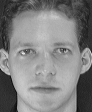

In [3]:
Image.open("Faces for training/orl_faces/s1/1.pgm")

In [4]:
img = read_image('Faces for training/orl_faces/s1/1.pgm')
img.shape

(112, 92)

In [5]:
size = 2
total_sample_size = 10000


def get_data(size, total_sample_size):
    image = read_image('Faces for training/orl_faces/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    image = image[::size, ::size]
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0

    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            img1 = read_image('Faces for training/orl_faces/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('Faces for training/orl_faces/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('Faces for training/orl_faces/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image('Faces for training/orl_faces/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            y_imposite[count] = 0
            count += 1
            
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

In [6]:
X, Y = get_data(size, total_sample_size)
print(X.shape)
print(Y.shape)

(20000, 2, 1, 56, 46)
(20000, 1)


In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

In [8]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    #nb_filter = [18, 12]
    kernel_size = 3
    
    seq.add(Convolution2D(nb_filter[0], kernel_size, strides=kernel_size, input_shape=input_shape, padding="valid", data_format="channels_first"))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))
    
    seq.add(Convolution2D(nb_filter[1], kernel_size, strides=kernel_size, padding="valid", data_format="channels_first"))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first")) 
    seq.add(Dropout(.25))

    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq

In [9]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [10]:
def _get_available_gpus():  

    if tfback._LOCAL_DEVICES is None:  
        devices = tf.config.list_logical_devices()  
        tfback._LOCAL_DEVICES = [x.name for x in devices]  
    return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]

tfback._get_available_gpus = _get_available_gpus

base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

In [11]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [12]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])
epochs = 13
rms = RMSprop()

model = Model(inputs=[img_a, img_b], outputs=distance)

def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 56, 46)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1, 56, 46)    0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 50)           10046       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           sequential_1[1][0]         

In [13]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]
model.fit([img_1, img2], y_train, validation_split=.25,
          batch_size=128, verbose=2, epochs=epochs)

Train on 11250 samples, validate on 3750 samples
Epoch 1/13
 - 4s - loss: 0.2543 - val_loss: 0.3611
Epoch 2/13
 - 3s - loss: 0.2502 - val_loss: 0.3445
Epoch 3/13
 - 3s - loss: 0.2438 - val_loss: 0.2860
Epoch 4/13
 - 3s - loss: 0.2257 - val_loss: 0.2150
Epoch 5/13
 - 3s - loss: 0.2022 - val_loss: 0.1766
Epoch 6/13
 - 3s - loss: 0.1912 - val_loss: 0.1659
Epoch 7/13
 - 3s - loss: 0.1818 - val_loss: 0.1512
Epoch 8/13
 - 3s - loss: 0.1724 - val_loss: 0.1497
Epoch 9/13
 - 3s - loss: 0.1671 - val_loss: 0.1388
Epoch 10/13
 - 3s - loss: 0.1645 - val_loss: 0.1359
Epoch 11/13
 - 3s - loss: 0.1583 - val_loss: 0.1300
Epoch 12/13
 - 3s - loss: 0.1573 - val_loss: 0.1389
Epoch 13/13
 - 3s - loss: 0.1522 - val_loss: 0.1242


In [14]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [15]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()
compute_accuracy(pred, y_test)

0.7586641461877757

In [16]:
model.save('self-trained models/Siamese_network.model')

#new_model = tf.keras.models.load_model('self-trained models/Siamese_network.model', custom_objects={'contrastive_loss': contrastive_loss})
#predictions = new_model.predict([x_test[:, 0], x_test[:, 1]])

Predict distance between faces: [0.03921344]
Face to compare 1:


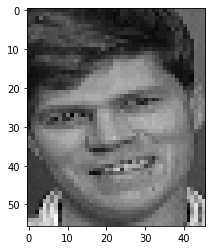

Face to compare 2:


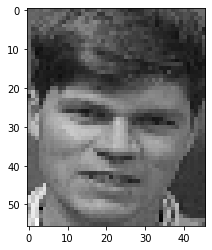

In [17]:
print('Predict distance between faces:', pred[1])

print('Face to compare 1:')
plt.imshow(x_test[:, 0][1].reshape(56, 46), cmap='gray')
plt.show()

print('Face to compare 2:')
plt.imshow(x_test[:, 1][1].reshape(56, 46), cmap='gray')
plt.show()

In [18]:
print('One hot y_test value. 1 the pictures are the same, 0 if they are not:')
y_test[1][0]

One hot y_test value. 1 the pictures are the same, 0 if they are not:


1.0